In [1]:
import json
import os
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
from drug_named_entity_recognition import find_drugs
import json5
import sys

parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from path import DATA_PROCESSED_DOCUMENTS_DIR

In [2]:
chief_complaint = "shortness-of-breath"
folder_location = os.path.join(
    DATA_PROCESSED_DOCUMENTS_DIR / chief_complaint / "black-or-african-american"
)
b_docs = []
w_docs = []
for filename in os.listdir(folder_location):
    file_location = os.path.join(folder_location, filename)
    if os.path.isfile(file_location):
        with open(file_location) as d:
            try:
                file_contents = d.read()
                content = json.loads(file_contents)
                b_docs.append(content)
            except Exception as e:
                try:
                    # pull of first and last line, gpt sometimes response with a leading ```json and ends with ```
                    tmp = file_contents.splitlines(True)
                    while "{" not in tmp[0]:
                        tmp = tmp[1:]
                    while "}" not in tmp[-1]:
                        tmp = tmp[:-1]
                    tmp = "".join(tmp)
                    content = json5.loads(tmp)
                    b_docs.append(content)
                except Exception as e:
                    # print(f"{file_location} Error: {e}")
                    pass

folder_location = os.path.join(
    DATA_PROCESSED_DOCUMENTS_DIR / chief_complaint / "white-or-caucasian"
)
for filename in os.listdir(folder_location):
    file_location = os.path.join(folder_location, filename)
    if os.path.isfile(file_location):
        with open(file_location) as d:
            try:
                file_contents = d.read()
                content = json.loads(file_contents)
                w_docs.append(content)
            except Exception as e:
                try:
                    # pull of first and last line, gpt sometimes response with a leading ```json and ends with ```
                    tmp = file_contents.splitlines(True)
                    while "{" not in tmp[0]:
                        tmp = tmp[1:]
                    while "}" not in tmp[-1]:
                        tmp = tmp[:-1]
                    tmp = "".join(tmp)
                    content = json5.loads(tmp)
                    w_docs.append(content)
                except Exception as e:
                    # print(f"{file_location} Error: {e}")
                    pass

In [3]:
print(len(b_docs))
print(len(w_docs))

4933
4935


In [4]:
b_normalized_medications = []
for doc in b_docs:
    if doc.get("medications") is not None:
        res = []
        res = doc.get("medications").split(" ")
        try:
            res.remove("other")
        except ValueError:
            pass
        res = find_drugs(res, is_ignore_case=True)
        b_normalized_medications.append(res)
len(b_normalized_medications)

4917

In [5]:
b_normalized_medications[:2]

[[({'name': 'Lisinopril',
    'synonyms': {'Lisinopril',
     'Lisinoprilum',
     'Lysinopril',
     'Prinivil',
     'Zestril'},
    'medline_plus_id': 'a692051',
    'nhs_url': 'https://www.nhs.uk/medicines/lisinopril',
    'wikipedia_url': 'https://en.wikipedia.org/wiki/Lisinopril',
    'mesh_id': 'D002316',
    'drugbank_id': 'DB00722'},
   4,
   4),
  ({'name': 'Atorvastatin',
    'synonyms': {'Atorvastatin',
     'Lipitor',
     'Liptonorm',
     'Sortis',
     'atorvastatina',
     'atorvastatine',
     'atorvastatinum'},
    'medline_plus_id': 'a600045',
    'nhs_url': 'https://www.nhs.uk/medicines/atorvastatin',
    'wikipedia_url': 'https://en.wikipedia.org/wiki/Atorvastatin',
    'mesh_id': 'D019161',
    'drugbank_id': 'DB01076'},
   9,
   9)],
 [({'name': 'Lisinopril',
    'synonyms': {'Lisinopril',
     'Lisinoprilum',
     'Lysinopril',
     'Prinivil',
     'Zestril'},
    'medline_plus_id': 'a692051',
    'nhs_url': 'https://www.nhs.uk/medicines/lisinopril',
    'wiki

In [6]:
w_normalized_medications = []
for doc in w_docs:
    if doc.get("medications") is not None:
        res = []
        res = doc.get("medications").split(" ")
        try:
            res.remove("other")
        except ValueError:
            pass
        res = find_drugs(res, is_ignore_case=True)
        w_normalized_medications.append(res)
len(w_normalized_medications)

4923

In [7]:
# For each patient, parse out the medications and normalize them. De-dup them so each patient has each medication listed only once.
b_just_names = list(
    map(
        lambda n: set(list(map(lambda m: m[0].get("name"), n))),
        b_normalized_medications,
    )
)
b_normalized_medications_names = [
    element for sublist in b_just_names for element in sublist
]
w_just_names = list(
    map(
        lambda n: set(list(map(lambda m: m[0].get("name"), n))),
        w_normalized_medications,
    )
)
w_normalized_medications_names = [
    element for sublist in w_just_names for element in sublist
]
b_just_names[:5]
# print(len(b_normalized_medications_names))
# print(len(w_normalized_medications_names))

[{'Atorvastatin', 'Lisinopril'},
 {'Atorvastatin', 'Lisinopril'},
 {'Lisinopril'},
 set(),
 {'Metoprolol'}]

In [8]:
b_cv = CountVectorizer(analyzer="word")
b_cv_fit = b_cv.fit_transform(b_normalized_medications_names)
b_word_list = b_cv.get_feature_names_out()
b_count_list = b_cv_fit.toarray().sum(axis=0)

b_word_freq = dict(zip(b_word_list, b_count_list))


w_cv = CountVectorizer(analyzer="word")
w_cv_fit = w_cv.fit_transform(w_normalized_medications_names)
w_word_list = w_cv.get_feature_names_out()
w_count_list = w_cv_fit.toarray().sum(axis=0)

w_word_freq = dict(zip(w_word_list, w_count_list))

In [9]:
b_word_freq_df = pd.DataFrame(
    b_word_freq.items(), columns=["word", "b.frequency"]
).sort_values(by="b.frequency", ascending=False)
w_word_freq_df = pd.DataFrame(
    w_word_freq.items(), columns=["word", "w.frequency"]
).sort_values(by="w.frequency", ascending=False)

In [10]:
wf_df = w_word_freq_df.merge(b_word_freq_df, how="inner", on="word")

In [11]:
wf_df["w.frequency_pct"] = wf_df["w.frequency"] / wf_df["w.frequency"].sum()
wf_df["b.frequency_pct"] = wf_df["b.frequency"] / wf_df["b.frequency"].sum()
wf_df["frequency_pct_diff"] = wf_df["b.frequency_pct"] - wf_df["w.frequency_pct"]
wf_df["frequency_pct_diff_abs"] = wf_df["frequency_pct_diff"].abs()
# Sort by largest values in absolue difference
wf_df.sort_values(by="frequency_pct_diff", ascending=False).head(10)

,word,w.frequency,b.frequency,w.frequency_pct,b.frequency_pct,frequency_pct_diff,frequency_pct_diff_abs
8,metformin,98,133,0.016263,0.022535,0.006272,0.006272
4,amlodipine,326,351,0.054099,0.059471,0.005372,0.005372
12,furosemide,43,64,0.007136,0.010844,0.003708,0.003708
0,lisinopril,1382,1375,0.229340,0.232972,0.003632,0.003632
13,loratadine,42,54,0.006970,0.009149,0.002180,0.002180
15,losartan,30,39,0.004978,0.006608,0.001630,0.001630
16,hydrochlorothiazide,30,38,0.004978,0.006438,0.001460,0.001460
17,aspirin,20,28,0.003319,0.004744,0.001425,0.001425
6,metoprolol,122,126,0.020246,0.021349,0.001103,0.001103
14,ipratropium,32,35,0.005310,0.005930,0.000620,0.000620


In [12]:
# First order frequencies by magnature of difference (absolute value), take the top 200 words with the greatest difference,
# then re-sort by actual difference so when we plot the values will be sequential from smallest to largest bars
most = (
    wf_df.sort_values(by="frequency_pct_diff_abs", ascending=False)
    .head(200)
    .sort_values(by="frequency_pct_diff", ascending=False)
)

chart_data = {}

# Create a map with the word as the frequency, and the magnitude vector as the value\
# a vector of [0, n] will plot a blue bar
# a vector of [n, 0] will plot an orange bar
# a vector with a negative n [-n, 0] will plot a bar on the left
# a vector with a positive n [n, 0] will plot a bar on the right
# {"word": [-1, 0]} will plot an orange bar for "word" on the left of 0 with length 1
# {"word": [0, 0.5]} will plot a blue bar for "word" on the right of 0 with length 0.5
# in order to generate a good Positive Negative bar chart, we assign b freq to the left side (negative)
# and w freq to the right side (positive)
for row in most.iterrows():
    if row[1]["w.frequency_pct"] > row[1]["b.frequency_pct"]:
        # orange bars
        chart_data[row[1]["word"]] = [
            row[1]["w.frequency_pct"] - row[1]["b.frequency_pct"],
            0,
        ]
    else:
        # blue bars
        chart_data[row[1]["word"]] = [
            0,
            -(row[1]["b.frequency_pct"] - row[1]["w.frequency_pct"]),
        ]

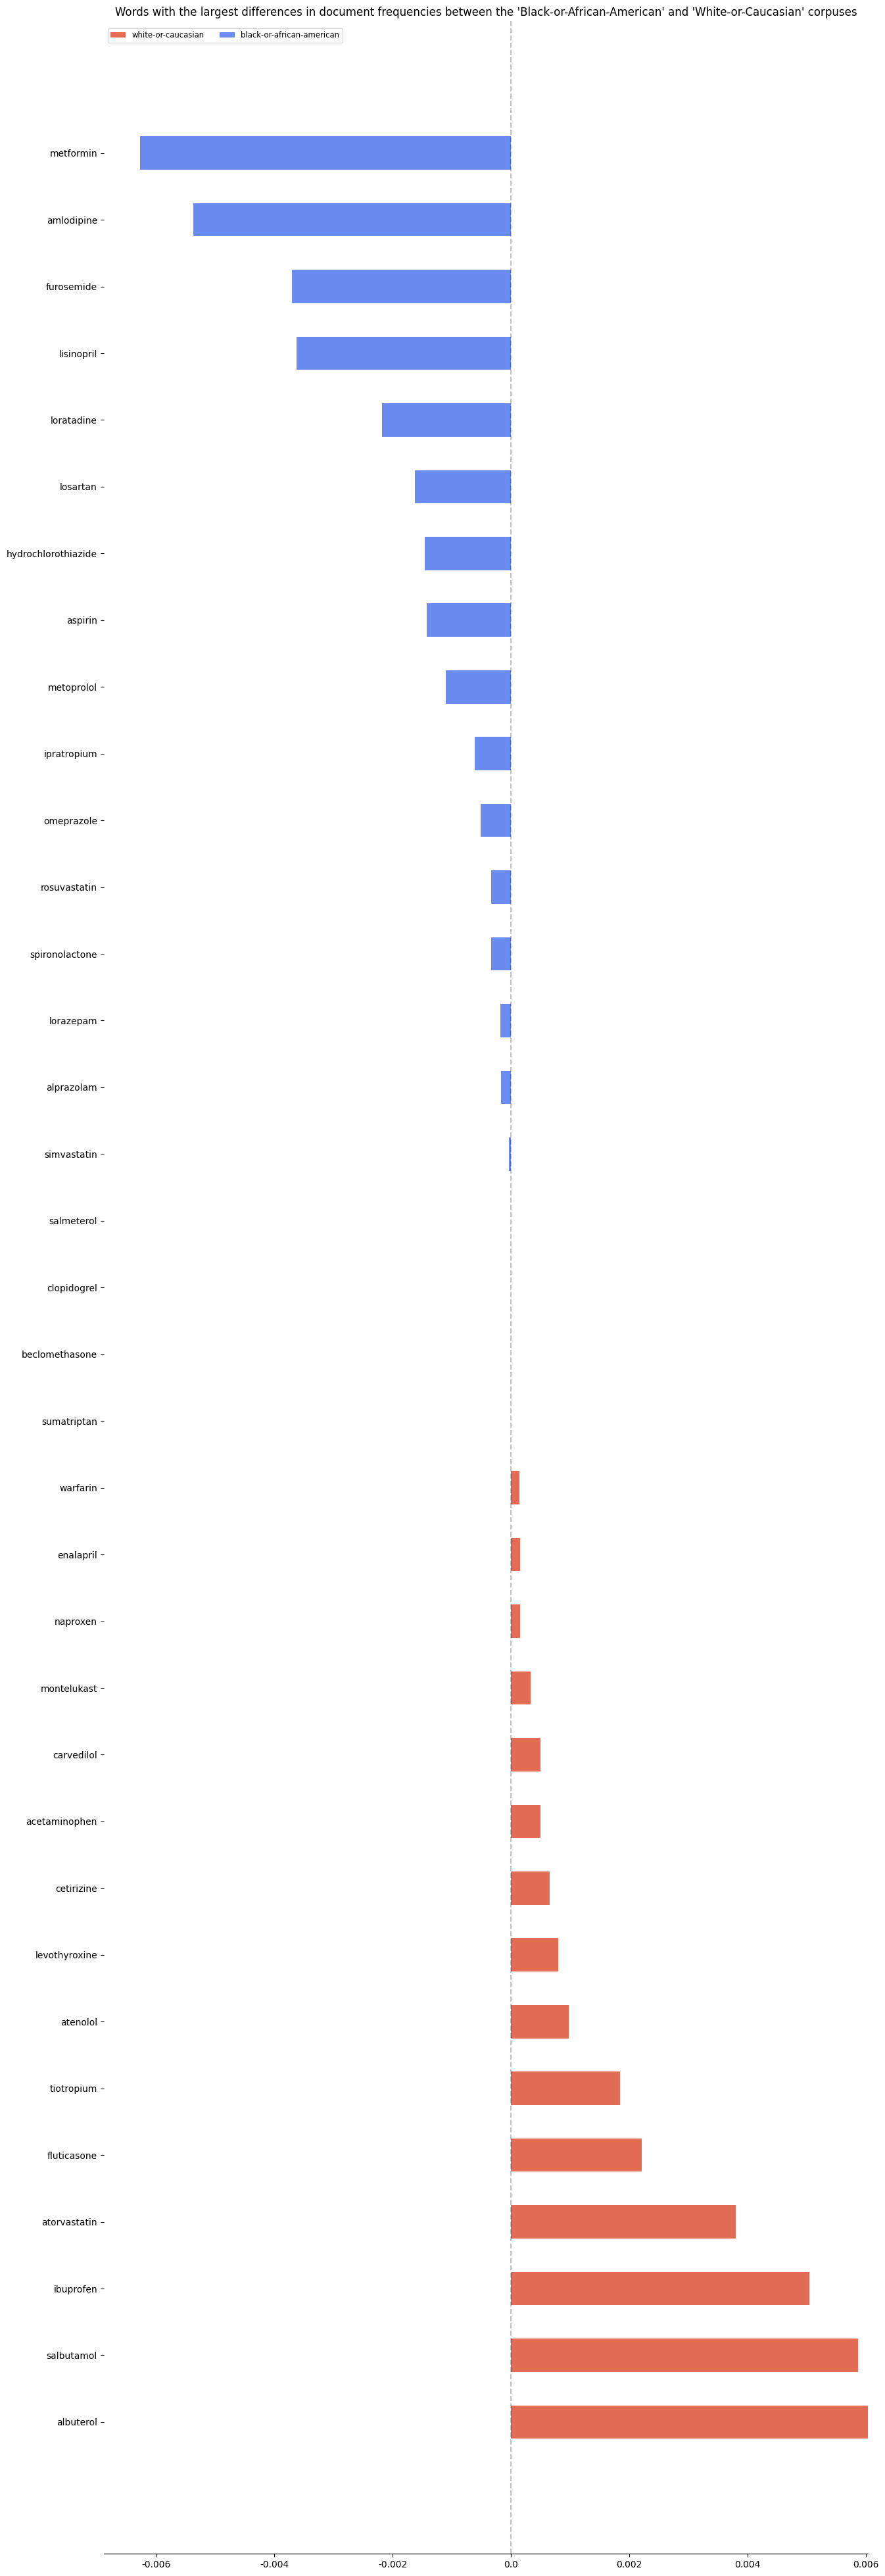

In [13]:
# Positive Negative Bar Chart to better visualize where word frequencies diverge between data sets
# Based on https://stackoverflow.com/a/69976552/11407943
import numpy as np
import matplotlib.pyplot as plt


category_names = ["white-or-caucasian", "black-or-african-american"]
results = chart_data


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*. The order is assumed
        to be from 'Strongly disagree' to 'Strongly aisagree'
    category_names : list of str
        The category labels.
    """

    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    middle_index = data.shape[1] // 2
    offsets = 0  # data[:, range(middle_index)].sum(axis=1) # + data[:, middle_index]/2

    # Color Mapping
    category_colors = plt.get_cmap("coolwarm_r")(np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(15, 50))

    # Plot Bars
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths - offsets
        rects = ax.barh(
            labels, widths, left=starts, height=0.5, label=colname, color=color
        )

    # Add Zero Reference Line
    ax.axvline(0, linestyle="--", color="black", alpha=0.25)

    # X Axis
    # ax.set_xticks(np.arange(-0.0035, 0.0035, 0.003))
    ax.xaxis.set_major_formatter(lambda x, pos: str(x))

    # Y Axis
    ax.invert_yaxis()

    # Remove spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Ledgend
    ax.legend(
        ncol=len(category_names),
        bbox_to_anchor=(0, 0.99),
        loc="lower left",
        fontsize="small",
    )

    # Set Background Color
    fig.set_facecolor("#FFFFFF")

    return fig, ax


fig, ax = survey(results, category_names)
plt.title(
    "Words with the largest differences in document frequencies between the 'Black-or-African-American' and 'White-or-Caucasian' corpuses"
)
plt.show()

In [14]:
import scipy
from sklearn.feature_extraction import text
from collections import Counter

In [15]:
b_just_names_lower = [list(map(lambda x: x.lower(), arr)) for arr in b_just_names]
b_list_of_doc_counter = list(map(Counter, b_just_names_lower))
# element for sublist in w_just_names for element in sublist
w_just_names_lower = [list(map(lambda x: x.lower(), arr)) for arr in w_just_names]
w_list_of_doc_counter = list(map(Counter, w_just_names_lower))
b_just_names_lower
b_medications_names_counter = Counter(
    [element for sublist in b_just_names_lower for element in sublist]
)
w_medications_names_counter = Counter(
    [element for sublist in w_just_names_lower for element in sublist]
)

In [16]:
b_medications_names_counter

Counter({'lisinopril': 1375,
         'albuterol': 1125,
         'salbutamol': 1125,
         'atorvastatin': 958,
         'amlodipine': 351,
         'simvastatin': 202,
         'metformin': 133,
         'metoprolol': 126,
         'acetaminophen': 94,
         'furosemide': 64,
         'loratadine': 54,
         'tiotropium': 42,
         'losartan': 39,
         'hydrochlorothiazide': 38,
         'ipratropium': 35,
         'fluticasone': 33,
         'ibuprofen': 29,
         'aspirin': 28,
         'levothyroxine': 9,
         'warfarin': 6,
         'atenolol': 5,
         'omeprazole': 4,
         'sertraline': 3,
         'rosuvastatin': 3,
         'enalapril': 3,
         'naproxen': 3,
         'cetirizine': 3,
         'lorazepam': 3,
         'spironolactone': 3,
         'salmeterol': 2,
         'alprazolam': 2,
         'lovastatin': 1,
         'escitalopram': 1,
         'budesonide': 1,
         'donepezil': 1,
         'montelukast': 1,
         'beclomethason

In [17]:
w_medications_names_counter

Counter({'lisinopril': 1382,
         'albuterol': 1185,
         'salbutamol': 1184,
         'atorvastatin': 1001,
         'amlodipine': 326,
         'simvastatin': 206,
         'metoprolol': 122,
         'acetaminophen': 99,
         'metformin': 98,
         'ibuprofen': 60,
         'tiotropium': 54,
         'fluticasone': 47,
         'furosemide': 43,
         'loratadine': 42,
         'ipratropium': 32,
         'hydrochlorothiazide': 30,
         'losartan': 30,
         'aspirin': 20,
         'levothyroxine': 14,
         'atenolol': 11,
         'cetirizine': 7,
         'warfarin': 7,
         'enalapril': 4,
         'carvedilol': 4,
         'naproxen': 4,
         'montelukast': 3,
         'lorazepam': 2,
         'salmeterol': 2,
         'rosuvastatin': 1,
         'beclomethasone': 1,
         'alprazolam': 1,
         'clopidogrel': 1,
         'sumatriptan': 1,
         'spironolactone': 1,
         'omeprazole': 1})

In [18]:
total_keys = list(
    set(
        list(w_medications_names_counter.keys())
        + list(b_medications_names_counter.keys())
    )
)
new_counts = {}
aa = []
ca = []
for k in total_keys:
    # [aa,ca]
    new_counts[k] = [
        b_medications_names_counter.get(k, 0),
        w_medications_names_counter.get(k, 0),
    ]
    aa.append(b_medications_names_counter.get(k, 0))
    ca.append(w_medications_names_counter.get(k, 0))

c_table = pd.DataFrame.from_dict(new_counts)
c_table.rename(index={0: "b.freq"}, inplace=True)
c_table.rename(index={1: "w.freq"}, inplace=True)
c_table

,atorvastatin,montelukast,losartan,alprazolam,salmeterol,hydrochlorothiazide,albuterol,ibuprofen,acetaminophen,simvastatin,...,sertraline,cetirizine,metoprolol,carvedilol,omeprazole,tiotropium,sumatriptan,furosemide,clopidogrel,ipratropium
b.freq,958,1,39,2,2,38,1125,29,94,202,...,3,3,126,1,4,42,1,64,1,35
w.freq,1001,3,30,1,2,30,1185,60,99,206,...,0,7,122,4,1,54,1,43,1,32


In [19]:
class bcolors:
    HEADER = "\033[95m"
    OKBLUE = "\033[94m"
    OKCYAN = "\033[96m"
    OKGREEN = "\033[92m"
    WARNING = "\033[93m"
    FAIL = "\033[91m"
    ENDC = "\033[0m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"

In [20]:
sig_results = []
# Chi square independence test
# https://www.dir.uniupo.it/pluginfile.php/138296/mod_resource/content/0/22-colloc-bw.pdf
for k in list(set(total_keys)):
    # For AA [Number of instances of current word, Number of instances of all other words]
    x1 = [c_table[k].iloc[0], c_table.iloc[0].sum() - c_table[k].iloc[0]]
    # For CA [Number of instances of current word, Number of instances of all other words]
    y1 = [c_table[k].iloc[1], c_table.iloc[1].sum() - c_table[k].iloc[1]]
    test = scipy.stats.chi2_contingency([x1, y1])
    word = c_table[k].name
    if test.pvalue < 0.05:
        sig_results.append(word)
        print(f"{bcolors.OKGREEN}{bcolors.BOLD}Medication: {k}{bcolors.ENDC}")
        print(f"AA: {x1}")
        print(f"CA: {y1}")
        print(
            f'There {bcolors.OKGREEN}is a significant difference{bcolors.ENDC} in the use of medication "{word}" between the groups with a p-value of {bcolors.OKGREEN +"{:0.3f}".format(test.pvalue) + bcolors.ENDC}'
        )
        print(f"")
    # else:
    #     print(f"{bcolors.FAIL}{bcolors.BOLD}Medication: {k}{bcolors.ENDC}")
    #     print(f"AA: {x1}")
    #     print(f"CA: {y1}")
    #     print(
    #         f'There {bcolors.FAIL}is no significant difference{bcolors.ENDC} in the use of medication "{word}" between the groups with a p-value of {bcolors.FAIL +"{:0.3f}".format(test.pvalue) + bcolors.ENDC}'
    #     )
    #     print(f"")
if len(sig_results) == 0:
    print(
        f"{bcolors.BOLD}{bcolors.FAIL}No significant differences in any conditions between groups found{bcolors.ENDC}"
    )

Medication: metformin
AA: [133, 5778]
CA: [98, 5928]
There is a significant difference in the use of medication "metformin" between the groups with a p-value of 0.016

Medication: furosemide
AA: [64, 5847]
CA: [43, 5983]
There is a significant difference in the use of medication "furosemide" between the groups with a p-value of 0.041

Medication: ibuprofen
AA: [29, 5882]
CA: [60, 5966]
There is a significant difference in the use of medication "ibuprofen" between the groups with a p-value of 0.002

